# はじめに
DP-SGDで教師データのプライバシーを保護しつつ、高いテスト精度を実現することを目指します。  
学習は以前の[Jupyter Notebook](https://github.com/toshi-4886/privacy_preserving_ML/blob/main/PyTorch/1_DPSGD_baseline.ipynb)をベースにしています。

### 概要
- ResNet18によるCIFAR-10の学習に、[Opacus](https://opacus.ai/)を用いてDP-SGDを適用する。
- DP-SGDの学習における$\sigma$と$C$の影響を確認する。


### 参考資料
- Building an Image Classifier with Differential Privacy (Opacus Tutorials)  
https://opacus.ai/tutorials/building_image_classifier
- PyTorch Quickstart  
https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html


# 実装

### 1. ライブラリのインポート
必要なライブラリをインポートします。


In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

!pip install 'opacus>=1.0'
import opacus
from opacus.validators import ModuleValidator
from opacus.utils.batch_memory_manager import BatchMemoryManager

import warnings
warnings.simplefilter("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 KB 4.8 MB/s eta 0:00:00


### 2. 実行環境の確認
使用するライブラリのバージョンや、GPU環境を確認します。  
Opacusは1.0.0で書き方が大きく変わっているので注意してください。  
[Google Colaboratory](https://colab.research.google.com/?hl=ja)で実行した際の例になります。

In [ ]:
print('Python:', sys.version)
print('PyTorch:', torch.__version__)
print('Torchvision:', torchvision.__version__)
print('Opacus:', opacus.__version__)
!nvidia-smi

Python: 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
PyTorch: 2.0.0+cu118
Torchvision: 0.15.1+cu118
Opacus: 1.4.0
Tue Apr  4 09:00:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------

### 3. データセットの用意  

#### データセットの取得
カラー画像データセットの[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)を、torchvisionを用いて取得します。  
[以前の結果](https://github.com/toshi-4886/privacy_preserving_ML/blob/main/PyTorch/2_DPSGD_regularization.ipynb)に基づいて、教師データにdata augmentationは適用せずに、前処理は下記のみを適用します。
- ToTensor：データをTensor型に変換
- Normalize：各チャネルの平均が0、標準偏差が1となるように標準化


In [ ]:
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2470, 0.2435, 0.2616)

training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)]),
)


test_data = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)]),
)

100%|██████████| 170498071/170498071 [00:16<00:00, 10231244.77it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### 4. 学習の関数化

今回は、異なる条件で複数回学習を実行するため、学習部分を関数として定義します。
各エポックのテスト精度と消費した$\epsilon$を出力します。

In [ ]:
def training(optim='Adam', lr=1e-3, batch_size = 512, sigma=1.0, c=1.0):    
    # make dataloader
    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=1024, shuffle=False)

    # make model
    model = torchvision.models.resnet18()
    model = ModuleValidator.fix(model)

    device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
    model = model.to(device)

    # make optimizer
    criterion = torch.nn.CrossEntropyLoss()
    if optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    elif optim == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=1e-4)
    elif optim == 'MSGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr,  momentum=0.9, weight_decay=1e-4)
    elif optim == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)

    # DP-SGD settig
    privacy_engine = opacus.PrivacyEngine()
    model, optimizer, train_dataloader = privacy_engine.make_private(
        module=model,
        optimizer=optimizer,
        data_loader=train_dataloader,
        noise_multiplier=sigma,
        max_grad_norm=c,
    )

    # training 
    test_acc = []
    epsilon = []

    pbar = tqdm(range(15), desc=f"[sigma: {sigma}, c: {c}]")
    for epoch in pbar:
            
        with BatchMemoryManager(
            data_loader=train_dataloader, 
            max_physical_batch_size=64, 
            optimizer=optimizer
        ) as memory_safe_data_loader:
            model.train()
            for (X, y) in memory_safe_data_loader:
                X, y = X.to(device), y.to(device)

                # optimization step
                optimizer.zero_grad()
                pred = model(X)
                loss = criterion(pred, y)
                loss.backward()
                optimizer.step()

        # calculate epsilon
        epsilon.append(privacy_engine.get_epsilon(1e-5))
    
        # test
        model.eval()
        pred_list = []
        y_list = []
        with torch.no_grad():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)

                # predict
                pred = model(X)
                loss = criterion(pred, y)

                y_list.extend(y.to('cpu').numpy().tolist())
                pred_list.extend(pred.argmax(1).to('cpu').numpy().tolist())

        test_acc.append(metrics.accuracy_score(y_list, pred_list))
        pbar.set_postfix(epsilon=epsilon[-1],test_acc=test_acc[-1])
    return epsilon, test_acc
    

### 5. 学習
DP-SGDのパラメータ$\sigma$と$C$を変えて学習を行います。   
DP-SGDでは、ニューラルネットワークのパラメータ$\theta$を下記のように更新します。
$$
\theta_{i+1} \leftarrow \theta_i - \eta \left( \frac{1}{|B|} \sum_{(x,y)\in B} {\rm clip}_C (\nabla_{\theta}\ell(f(x), y)) + Z\right)
$$
ここで、$\ell$は損失関数、${\rm clip}_C$はL2ノルムを$C$に制限する関数、$Z$は多変量正規分布$\mathcal{N}(0,\sigma^2C^2\mathbb{I})$に従うノイズです。  
この中で、$\sigma$と$C$がDP-SGD特有のパラメータになります。  





In [ ]:
result = {}

for sigma in [0.5, 1.0]:
    for c in [0.1, 1.0, 10]:
        epsilon, test_acc = training(sigma=sigma, c=c)
        result[(sigma, c)] = (epsilon, test_acc)

[sigma: 1.0, c: 10]: 100%|██████████| 15/15 [21:30<00:00, 86.05s/it, epsilon=2.27, test_acc=0.502]


### 6. 学習結果の表示
学習結果として、消費した$\epsilon$とテストデータの精度を描画します。

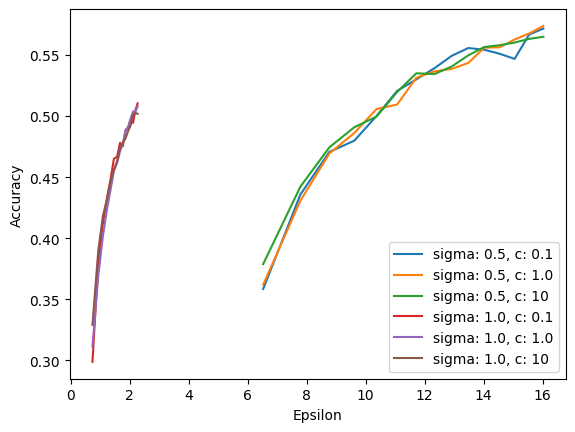

In [ ]:

for val, res in result.items():
    epsilon, test_acc = res
    plt.plot(epsilon, test_acc, label=f'sigma: {val[0]}, c: {val[1]}')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# おわりに


### 今回の結果
$C$の値を変えても結果はほぼ変わりませんでした、一方で$\sigma$を小さくすると、学習時のノイズの大きさが小さくなるので、消費する$\epsilon$が増大し、テスト精度も少し改善することが分かりました。   

これまで目安としていた$\epsilon=2$で学習を行うために、今後も$\sigma=1.0$と$C=1.0$を採用しようと思います。

### 次にやること
ニューラルネットワークの種類を変えることでDP-SGDのテスト精度がどう変わるか検証したいと思います。



